# Fit a Neural Network

Previously, I fit a simple sklearn GP and logged it in mlflow. Let's now try something a little more complicated - a neural network!

In [1]:
# MLFlow setup

import mlflow

# Manually specify this uri when launching the server in $HOME with mlflow ui --port 8080
# Setting the tracking uri to the one launched from home will prevent a new mlflow instance in each directory
mlflow.set_tracking_uri("http://127.0.0.1:8080")
client = mlflow.MlflowClient()

# Search for the experiment we want to be working in, which will be sandbox as we play around
experiment_list = client.search_experiments(filter_string="name = 'Default'")
experiment_id = experiment_list[0].experiment_id
mlflow.set_experiment(experiment_id=experiment_id)

<Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1708732941708, experiment_id='0', last_update_time=1708732941708, lifecycle_stage='active', name='Default', tags={}>

In [4]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import os

mlflow.pytorch.autolog()


class LightningMNISTClassifier(pl.LightningModule):

    def __init__(self):
        super().__init__()

        # mnist images are (1, 28, 28) (channels, width, height)
        self.layer_1 = torch.nn.Linear(28 * 28, 128)
        self.layer_2 = torch.nn.Linear(128, 256)
        self.layer_3 = torch.nn.Linear(256, 10)

    def forward(self, x):
        batch_size, channels, width, height = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)

        # layer 1 (b, 1*28*28) -> (b, 128)
        x = self.layer_1(x)
        x = torch.relu(x)

        # layer 2 (b, 128) -> (b, 256)
        x = self.layer_2(x)
        x = torch.relu(x)

        # layer 3 (b, 256) -> (b, 10)
        x = self.layer_3(x)

        # probability distribution over labels
        x = torch.log_softmax(x, dim=1)

        return x

    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


# data
# transforms for images
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# prepare transforms standard to MNIST
mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)

train_dataloader = DataLoader(mnist_train, batch_size=64)
val_loader = DataLoader(mnist_test, batch_size=64)

# train
model = LightningMNISTClassifier()
trainer = pl.Trainer(max_epochs=20)

trainer.fit(model, train_dataloader, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 100 K 
1 | layer_2 | Linear | 33.0 K
2 | layer_3 | Linear | 2.6 K 
-----------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=20` reached.


In [5]:
mlflow.pytorch.log_model(
    pytorch_model=model,
    artifact_path="torch-model",
    registered_model_name="mnist-nn",
)

Registered model 'mnist-nn' already exists. Creating a new version of this model...
2024/02/23 17:05:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: mnist-nn, version 2
Created version '2' of model 'mnist-nn'.


And pytorch below, which doesn't get autologged.

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


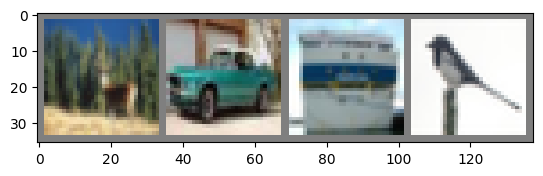

deer  car   ship  bird 


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

Define a CNN

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Define loss and optimizer

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Train the CNN

In [9]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

print("Finished Training")

[1,  2000] loss: 1.264
[1,  4000] loss: 1.288
[1,  6000] loss: 1.277
[1,  8000] loss: 1.260
[1, 10000] loss: 1.223
[1, 12000] loss: 1.227
[2,  2000] loss: 1.169
[2,  4000] loss: 1.136
[2,  6000] loss: 1.160
[2,  8000] loss: 1.150
[2, 10000] loss: 1.136
[2, 12000] loss: 1.167
[3,  2000] loss: 1.079
[3,  4000] loss: 1.087
[3,  6000] loss: 1.068
[3,  8000] loss: 1.074
[3, 10000] loss: 1.072
[3, 12000] loss: 1.072
Finished Training


In [20]:
mlflow.pytorch.log_model(
    pytorch_model=net,
    artifact_path="torch-model",
    signature=mlflow.models.infer_signature(data[0].numpy()),
    registered_model_name="cifar-cnn",
)

Successfully registered model 'cifar-cnn'.
2024/02/23 16:41:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: cifar-cnn, version 1
Created version '1' of model 'cifar-cnn'.
